## **Transfer Learning for Image Classification**

Hi I'm Annop :D. Welcome to this notebook on transfer learning, where I will walk you through the basic concepts and techniques involved in this powerful approach to deep learning. Specifically, we will explore how transfer learning can be used to classify four different types of sheep breed, even with a relatively small dataset.

**Transfer learning** is a technique that involves taking a pre-trained neural network, often on a large dataset, and then adapting it for use on a smaller, more specific task. This can save time and computational resources, and often leads to better performance than training a new model from scratch. There are two main techniques involved in transfer learning: feature extraction and fine-tuning.

1. **Feature extraction** involves using the pre-trained neural network as a fixed feature extractor, freezing the weights and biases of the initial layers, and only training the final layers on the new task-specific dataset. This is particularly useful when the new dataset is small or similar to the original dataset on which the pre-trained network was trained.

2. **Fine-tuning**, on the other hand, involves unfreezing some of the earlier layers of the pre-trained network, and then training the entire network on the new task-specific dataset. This is often used when the new dataset is larger and more diverse than the original dataset, and the initial layers need to be adapted to the new data.

So, let's get started and explore how transfer learning can be applied to classify sheep breeds! 

In [32]:
import random
import cv2
import matplotlib.pyplot as plt
from glob import glob
import os
from mpl_toolkits.axes_grid1 import ImageGrid
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from albumentations.pytorch import ToTensorV2
import albumentations as A
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 1. Dataset Exploration
To start off, it's essential to explore the dataset thoroughly as it provides us with valuable insights that can lead to the development of better models. For image dataset tasks, there are various ways to explore the dataset such as. In this section, we'll be using the simplest approach which is to plot the images.

In [3]:
def plot_samples_images(im_path, n_samples=20):
    if n_samples % 5 != 0 :
        raise ValueError('n_samples should be divisible by 5')

    im_path = glob(im_path + "/**/**/*")
    im_path = random.sample(im_path, n_samples)

    image_data = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in im_path]
    fig = plt.figure(figsize=(15., 15.))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(n_samples // 5, 5),
                     axes_pad=0.3
                     )
    labels = [path.split('/')[-2] for path in im_path]

    for index, (ax, im) in enumerate(zip(grid, image_data)):
        ax.imshow(im)
        ax.title.set_text(labels[index])

    plt.show()

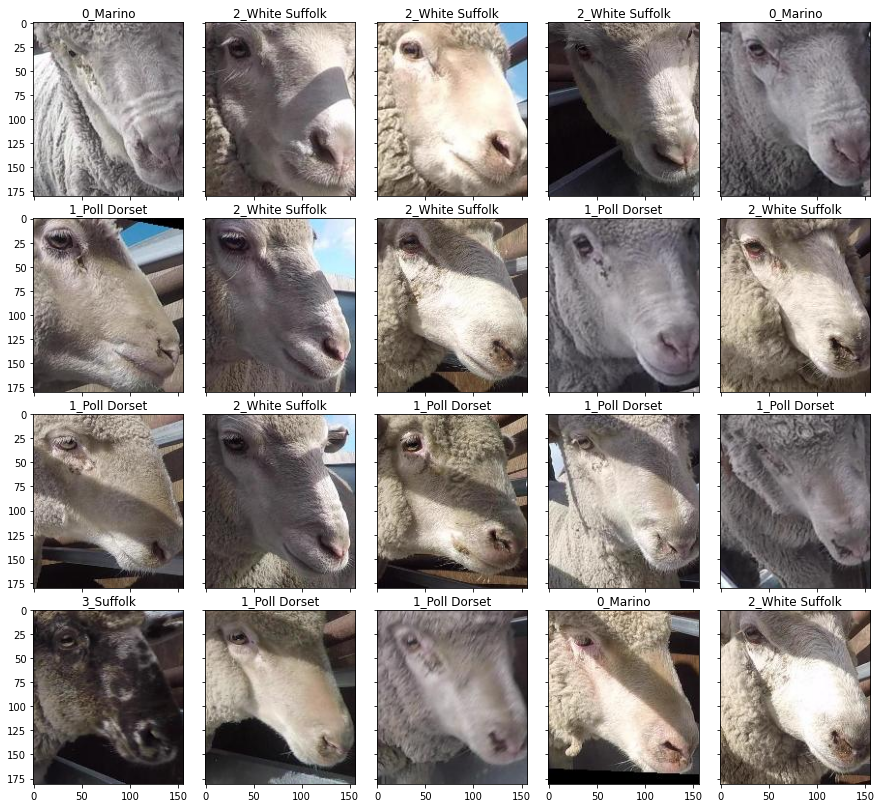

In [4]:
plot_samples_images("/content/drive/MyDrive/sheep_breed/SheepFaceImages")

Normally, it's essential to analyze the distribution of images in terms of their size and intensity by plotting histograms. This exploration process helps us better understand the data characteristics, leading to the development of more effective models. However, since this dataset consists of cropped images of sheep faces, all images will have the same size. Therefore, there is no need to explore the size distribution.

# 2. Prepare Dataset & DataLoader
In this notebook, we will be using PyTorch to train our deep learning model. The first step in this process is to prepare the dataset & data loader, which will allow us to load and transform the data before training the model.

Let's start by defining our Dataset class

In [5]:
class SheepDataset(Dataset):
    def __init__(
            self,
            root_dir,
            mode = 'train',
            transforms = None
            ):
        if mode == 'train':
            self.im_paths = sorted(glob(root_dir + '/train/**/*.jpg'))
        elif mode == 'test':
            self.im_paths = sorted(glob(root_dir + '/test/**/*.jpg'))
        elif mode == 'val':
            self.im_paths = sorted(glob(root_dir + '/val/**/*.jpg'))
        self.transforms = transforms

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, index):
        im_path = self.im_paths[index]
        image = cv2.imread(im_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image / 255.0

        label = im_path.split("/")[-2].split("_")[0]
        label = torch.tensor(int(label)).long()

        if self.transforms is not None:
            augmentations = self.transforms(image=image)
            image = augmentations["image"]
            image = image.float()

        return image, label

In [6]:
transforms = A.Compose(
            [
                A.Resize(height=150, width=150),
                ToTensorV2(),
            ]
        )

In [7]:
train_dataset = SheepDataset(root_dir="/content/drive/MyDrive/sheep_breed/SheepFaceImages", transforms=transforms)
val_dataset = SheepDataset(root_dir="/content/drive/MyDrive/sheep_breed/SheepFaceImages", mode='val', transforms=transforms)
test_dataset = SheepDataset(root_dir="/content/drive/MyDrive/sheep_breed/SheepFaceImages", mode='test', transforms=transforms)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# 3. Initialize pre-trained network
The core principle of transfer learning is to transfer knowledge from a bigger task to a smaller one with the assumption that the learned features in the bigger task will be useful for the smaller task. Thus, using a pre-trained CNN network with ImageNet can be a good starting point since it has learned to recognize a diverse set of visual features. In this notebook, we will choose the ResNet50, which has shown to be effective in various computer vision tasks.


In [9]:
def initialize_model(num_classes, feature_extract):
      resnet50 = models.resnet50(weights=True)
      if feature_extract:
        for param in resnet50.parameters():
            param.requires_grad = False
      num_ftrs = resnet50.fc.in_features
      resnet50.fc = torch.nn.Linear(num_ftrs, num_classes)
      return resnet50

As metioned previously, There are 2 main technique for transfer learning : 

1.   Feature Extraction
2.   Fine-tuning

We'll start with Feature Extraction technique first. This can be easily done by freezing the parameters (weigh & bias) of ResNet50 model.

In [10]:
model = initialize_model(num_classes=4, feature_extract=True)
model = model.float()
model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 4. Model Training : Feature Extraction

With everything in place, it's time to start training the model using the feature extraction technique. This approach relies on the powerful pre-trained ResNet50 model to extract relevant features from the images. We will only train the classification layer using these extracted features, which helps us adjust the classifier to our task-specific dataset.

In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
model = model.to(device)

In [45]:
def train(train_loader, val_loader, optimizer, criterion, epoch=50):
  train_history = []
  val_history = []
  val_accs = []
  best_acc = 0
  for e in range(epoch):
    print(f'Epoch {e+1}')
    train_losses = []
    for data, labels in tqdm(train_loader):
      data, labels = data.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(data)
      train_loss = criterion(outputs,labels) 
      train_loss.backward()
      optimizer.step()

      train_losses.append(train_loss)

    train_history.append(torch.tensor(train_losses).mean())
    print(f'Training Loss: {torch.tensor(train_losses).mean():.2f}')
    
    model.eval()
    val_losses = []
    correct = 0
    total = 0
    with torch.no_grad():
      for data, labels in tqdm(val_loader):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        val_loss = criterion(outputs,labels)
        val_losses.append(val_loss)

        _, pred = outputs.max(1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()

    acc = 100.*correct/total
    val_accs.append(acc)
    val_history.append(torch.tensor(val_losses).mean())

    if acc > best_acc:
      print(f"Val acc improved from {best_acc} to {acc}, save weight")
      best_acc = acc
      save_name = "best_weight.pth"
      torch.save(model.state_dict(), save_name)

    print('Val Loss: %.3f | Accuracy: %.3f'%(torch.tensor(train_losses).mean(), acc))
  return train_history, val_history, val_accs

In [14]:
train_history, val_history, val_accs = train(train_loader, val_loader, optimizer, criterion, epoch=20)

Epoch 1


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 1.32


  0%|          | 0/17 [00:00<?, ?it/s]

Val acc improved from 0 to 52.23880597014925, save weight
Val Loss: 1.319 | Accuracy: 52.239
Epoch 2


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 1.16


  0%|          | 0/17 [00:00<?, ?it/s]

Val acc improved from 52.23880597014925 to 65.67164179104478, save weight
Val Loss: 1.160 | Accuracy: 65.672
Epoch 3


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 1.05


  0%|          | 0/17 [00:00<?, ?it/s]

Val acc improved from 65.67164179104478 to 74.6268656716418, save weight
Val Loss: 1.048 | Accuracy: 74.627
Epoch 4


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.95


  0%|          | 0/17 [00:00<?, ?it/s]

Val acc improved from 74.6268656716418 to 75.0, save weight
Val Loss: 0.953 | Accuracy: 75.000
Epoch 5


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.89


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.885 | Accuracy: 74.254
Epoch 6


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.83


  0%|          | 0/17 [00:00<?, ?it/s]

Val acc improved from 75.0 to 76.49253731343283, save weight
Val Loss: 0.828 | Accuracy: 76.493
Epoch 7


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.77


  0%|          | 0/17 [00:00<?, ?it/s]

Val acc improved from 76.49253731343283 to 81.34328358208955, save weight
Val Loss: 0.775 | Accuracy: 81.343
Epoch 8


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.74


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.736 | Accuracy: 79.851
Epoch 9


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.70


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.702 | Accuracy: 80.970
Epoch 10


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.67


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.673 | Accuracy: 81.343
Epoch 11


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.65


  0%|          | 0/17 [00:00<?, ?it/s]

Val acc improved from 81.34328358208955 to 82.46268656716418, save weight
Val Loss: 0.651 | Accuracy: 82.463
Epoch 12


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.62


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.615 | Accuracy: 81.343
Epoch 13


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.60


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.599 | Accuracy: 82.090
Epoch 14


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.58


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.576 | Accuracy: 81.716
Epoch 15


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.56


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.559 | Accuracy: 81.716
Epoch 16


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.54


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.544 | Accuracy: 81.343
Epoch 17


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.53


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.531 | Accuracy: 81.716
Epoch 18


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.52


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.516 | Accuracy: 81.716
Epoch 19


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.51


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.509 | Accuracy: 81.343
Epoch 20


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.49


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.488 | Accuracy: 81.343
Epoch 21


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.48


  0%|          | 0/17 [00:00<?, ?it/s]

Val acc improved from 82.46268656716418 to 82.83582089552239, save weight
Val Loss: 0.481 | Accuracy: 82.836
Epoch 22


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.47


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.474 | Accuracy: 80.970
Epoch 23


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.46


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.460 | Accuracy: 82.463
Epoch 24


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.44


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.444 | Accuracy: 82.463
Epoch 25


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.45


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.447 | Accuracy: 81.716
Epoch 26


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.43


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.432 | Accuracy: 81.343
Epoch 27


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.43


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.429 | Accuracy: 82.463
Epoch 28


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.41


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.414 | Accuracy: 82.090
Epoch 29


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.41


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.410 | Accuracy: 82.463
Epoch 30


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.40


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.404 | Accuracy: 82.463
Epoch 31


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.39


  0%|          | 0/17 [00:00<?, ?it/s]

Val acc improved from 82.83582089552239 to 83.2089552238806, save weight
Val Loss: 0.395 | Accuracy: 83.209
Epoch 32


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.39


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.390 | Accuracy: 81.716
Epoch 33


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.38


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.383 | Accuracy: 82.090
Epoch 34


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.38


  0%|          | 0/17 [00:00<?, ?it/s]

Val acc improved from 83.2089552238806 to 83.95522388059702, save weight
Val Loss: 0.375 | Accuracy: 83.955
Epoch 35


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.37


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.369 | Accuracy: 83.209
Epoch 36


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.36


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.365 | Accuracy: 82.836
Epoch 37


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.36


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.362 | Accuracy: 82.836
Epoch 38


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.35


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.351 | Accuracy: 82.090
Epoch 39


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.35


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.348 | Accuracy: 83.582
Epoch 40


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.35


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.346 | Accuracy: 83.955
Epoch 41


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.34


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.338 | Accuracy: 82.090
Epoch 42


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.33


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.331 | Accuracy: 83.582
Epoch 43


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.33


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.327 | Accuracy: 83.582
Epoch 44


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.32


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.325 | Accuracy: 81.343
Epoch 45


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.32


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.321 | Accuracy: 83.209
Epoch 46


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.32


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.316 | Accuracy: 83.582
Epoch 47


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.32


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.319 | Accuracy: 82.090
Epoch 48


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.31


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.313 | Accuracy: 81.716
Epoch 49


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.31


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.306 | Accuracy: 83.582
Epoch 50


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.30


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.302 | Accuracy: 82.836


Once the training process is done, we can then evaluate the performance

In [88]:
def test_model(test_loader, model):
    model.eval()
    correct = 0
    total = 0
    all_label = []
    all_conf = []
    all_pred = []
    with torch.no_grad():
      for data, labels in tqdm(test_loader):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        scores = torch.nn.functional.softmax(outputs, dim=1)
        conf, pred = torch.max(scores,1)

        total += labels.size(0)
        correct += pred.eq(labels).sum().item()

        all_label.append(labels.cpu())
        all_pred.append(pred)
        all_conf.append(conf)

    all_conf = torch.cat(all_conf).cpu().numpy()
    all_label = torch.cat(all_label).cpu().numpy()
    all_pred = torch.cat(all_pred).cpu().numpy()
    return correct, total, all_label, all_pred, all_conf

In [ ]:
weight = torch.load("best_weight.pth")
model.load_state_dict(weight)

In [ ]:
correct, total, all_label, all_pred, all_conf = test_model(test_loader, model)
class_mapping = {0:'Marino', 1:'Poll Dorset', 2:'White Suffolk', 3:'Suffolk'}
all_label = [class_mapping[label] for label in all_label]
all_pred = [class_mapping[pred] for pred in all_pred]
print(classification_report(all_label, all_pred))

  0%|          | 0/17 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.75      0.78      0.76        67
           1       0.75      0.81      0.78        67
           2       0.89      0.75      0.81        67
           3       0.93      0.99      0.96        67

    accuracy                           0.83       268
   macro avg       0.83      0.83      0.83       268
weighted avg       0.83      0.83      0.83       268



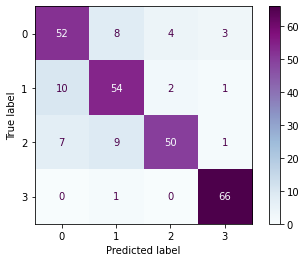

In [36]:
confusionMatrix = confusion_matrix(all_label, all_pred)
ConfusionMatrixDisplay(confusionMatrix, display_labels=list(class_mapping.values())).plot(cmap='BuPu')

You can see that the results look pretty good, with the model being able to correctly classify the 4 types of sheep breed. However, there are still a few misclassifications in each class. To improve the model's performance, we will explore another transfer learning technique: fine-tuning. This technique allows us to further optimize the pre-trained model by unfreezing some of its layers and training them on our specific task, which can lead to better results.

# 5. Model Training : Fine-tuning

In this section, we will dive into the fine-tuning method, which allows us to further improve our model's performance. Fine-tuning is a transfer learning technique that involves training not only the final classification layer, but also some of the earlier layers of the pre-trained model. By adjusting the weights of these layers, the model can learn to recognize more task-specific features that were not captured by the pre-trained model. 

**Note**: it is important to be cautious and pay attention to certain details. Firstly, it is recommended to start with a small learning rate and gradually increase it to avoid any abrupt changes in the weights. Additionally, overfitting may occur if the model is too complex or the dataset is too small, so it is important to keep an eye on the validation loss during training to prevent this issue.

In [51]:
model = initialize_model(num_classes=4, feature_extract=False) #specify feature_extract to false
model = model.float()
model = model.to(device)

In [52]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5)

In [53]:
train_history, val_history, val_accs = train(train_loader, val_loader, optimizer, criterion, epoch=20)

Epoch 1


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 1.18


  0%|          | 0/17 [00:00<?, ?it/s]

Val acc improved from 0 to 76.86567164179104, save weight
Val Loss: 1.178 | Accuracy: 76.866
Epoch 2


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.36


  0%|          | 0/17 [00:00<?, ?it/s]

Val acc improved from 76.86567164179104 to 91.04477611940298, save weight
Val Loss: 0.362 | Accuracy: 91.045
Epoch 3


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.04


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.045 | Accuracy: 85.448
Epoch 4


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.02


  0%|          | 0/17 [00:00<?, ?it/s]

Val acc improved from 91.04477611940298 to 93.65671641791045, save weight
Val Loss: 0.021 | Accuracy: 93.657
Epoch 5


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.00


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.002 | Accuracy: 92.537
Epoch 6


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.00


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.001 | Accuracy: 92.910
Epoch 7


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.00


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.000 | Accuracy: 92.910
Epoch 8


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.00


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.000 | Accuracy: 92.910
Epoch 9


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.00


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.000 | Accuracy: 92.910
Epoch 10


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.00


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.000 | Accuracy: 92.910
Epoch 11


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.00


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.000 | Accuracy: 92.910
Epoch 12


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.00


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.000 | Accuracy: 92.910
Epoch 13


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.00


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.000 | Accuracy: 93.284
Epoch 14


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.00


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.000 | Accuracy: 93.284
Epoch 15


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.00


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.000 | Accuracy: 93.284
Epoch 16


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.00


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.000 | Accuracy: 93.284
Epoch 17


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.00


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.000 | Accuracy: 93.284
Epoch 18


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.00


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.000 | Accuracy: 92.910
Epoch 19


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.00


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.000 | Accuracy: 93.284
Epoch 20


  0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 0.00


  0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.000 | Accuracy: 93.284


In [89]:
weight = torch.load("best_weight.pth")
model.load_state_dict(weight)

<All keys matched successfully>

In [90]:
correct, total, all_label, all_pred, all_conf = test_model(test_loader, model)
class_mapping = {0:'Marino', 1:'Poll Dorset', 2:'White Suffolk', 3:'Suffolk'}
all_label = [class_mapping[label] for label in all_label]
all_pred = [class_mapping[pred] for pred in all_pred]
print(classification_report(all_label, all_pred))

  0%|          | 0/17 [00:00<?, ?it/s]

               precision    recall  f1-score   support

       Marino       0.90      0.94      0.92        67
  Poll Dorset       0.95      0.88      0.91        67
      Suffolk       0.97      0.99      0.98        67
White Suffolk       0.93      0.94      0.93        67

     accuracy                           0.94       268
    macro avg       0.94      0.94      0.94       268
 weighted avg       0.94      0.94      0.94       268



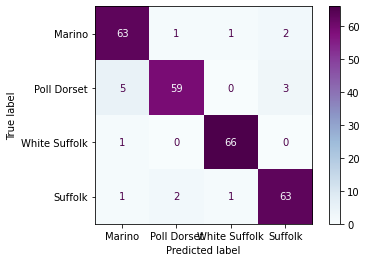

In [91]:
confusionMatrix = confusion_matrix(all_label, all_pred)
ConfusionMatrixDisplay(confusionMatrix, display_labels=list(class_mapping.values())).plot(cmap='BuPu')

## 6. Conclusion

Congratulations, you've just learned about transfer learning and how to apply it to classify different types of sheep breeds with a limited dataset. We explored two transfer learning techniques, feature extraction and fine-tuning, and saw how they can be used to train a deep learning model effectively.

In feature extraction, we used a pre-trained ResNet50 model to extract relevant features from the images and only trained the final classification layer on the new dataset. While in fine-tuning, we fine-tuned the pre-trained ResNet50 model on the new dataset by training both the feature extractor and classification layer with a small learning rate.

# Sample Prediction

In [105]:
rand_idx = random.randint(0, len(test_dataset))
data = test_dataset[rand_idx]
label = class_mapping[data[1].item()]
batch_img = data[0].unsqueeze(0)
batch_img = batch_img.to(device)

Text(0.5, 1.0, 'pred : Poll Dorset | label : Poll Dorset | confidence : 0.998')

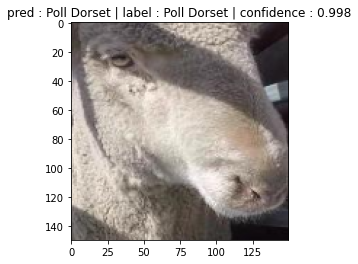

In [109]:
outputs = model(batch_img)
scores = torch.nn.functional.softmax(outputs, dim=1)
conf, pred = torch.max(scores,1)
conf = conf.cpu().item()
pred = class_mapping[pred.item()]

plt.imshow(batch_img.squeeze(0).permute(1,2,0).cpu())
plt.title(f"pred : {pred} | label : {label} | confidence : {round(conf,3)}")